In [662]:
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

from collections import Counter

import sklearn.datasets
import sklearn.preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
import sklearn.cluster

type Nums = np.ndarray[np.number]

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

In [663]:
data_object = sklearn.datasets.load_iris(as_frame=True)
data = data_object.frame
target_names = data_object.target_names

scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(data.iloc[:, :4])

encoder = sklearn.preprocessing.OneHotEncoder()
Y = encoder.fit_transform(data["target"].values[:, None]).toarray()

In [664]:
train_x, test_x, train_y, test_y = train_test_split(
    X, Y, train_size=0.7, stratify=data["target"]
)

In [665]:
def plot_centroids(centroids: Nums, coords2d: Nums):
    fig, (axes) = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axes[0, 0].scatter(X[:, 0], X[:, 1], c=data["target"])
    axes[0, 0].set_xlabel("sepal length (cm)")
    axes[0, 0].set_ylabel("sepal width (cm)")
    axes[0, 0].scatter(centroids[:, [0]], centroids[:, [1]], marker="o", c="red")

    axes[0, 1].scatter(X[:, 0], X[:, 2], c=data["target"])
    axes[0, 1].set_xlabel("sepal length (cm)")
    axes[0, 1].set_ylabel("petal length (cm)")
    axes[0, 1].scatter(centroids[:, [0]], centroids[:, [2]], marker="o", c="red")

    axes[0, 2].scatter(X[:, 0], X[:, 3], c=data["target"])
    axes[0, 2].set_xlabel("sepal length (cm)")
    axes[0, 2].set_ylabel("petal width (cm)")
    axes[0, 2].scatter(centroids[:, [0]], centroids[:, [3]], marker="o", c="red")

    axes[1, 0].scatter(X[:, 1], X[:, 2], c=data["target"])
    axes[1, 0].set_xlabel("sepal width (cm)")
    axes[1, 0].set_ylabel("petal length (cm)")
    axes[1, 0].scatter(centroids[:, [1]], centroids[:, [2]], marker="o", c="red")

    axes[1, 1].scatter(X[:, 1], X[:, 3], c=data["target"])
    axes[1, 1].set_xlabel("sepal width (cm)")
    axes[1, 1].set_ylabel("petal width (cm)")
    axes[1, 1].scatter(centroids[:, [1]], centroids[:, [3]], marker="o", c="red")

    axes[1, 2].scatter(X[:, 2], X[:, 3], c=data["target"])
    axes[1, 2].set_xlabel("petal length (cm)")
    axes[1, 2].set_ylabel("petal width (cm)")
    axes[1, 2].scatter(centroids[:, [2]], centroids[:, [3]], marker="o", c="red")

    fig.suptitle("Iris dataset", fontsize=16)

    to_plot_mapping = {
        (0, 1): (0, 0),
        (0, 2): (0, 1),
        (0, 3): (0, 2),
        (1, 2): (1, 0),
        (1, 3): (1, 1),
        (2, 3): (1, 2),
    }
    
    rows, cols, _ = coords2d.shape

    for dim_x in range(4):
        for dim_y in range(dim_x + 1, 4):
            for x in range(rows):
                for y in range(cols):
                    idx = x * cols + y
                    ax = axes[to_plot_mapping[(dim_x, dim_y)]]
                    neighboring_idx = (x + 1) * cols + y
                    if neighboring_idx < len(centroids):
                        con = ConnectionPatch(centroids[idx][[dim_x, dim_y]], centroids[neighboring_idx][[dim_x, dim_y]], "data", "data", axesA=ax, axesB=ax)
                        fig.add_artist(con)
                        
                    neighboring_idx = (x + 1) * cols + (y + 1)
                    if neighboring_idx < len(centroids):
                        con = ConnectionPatch(centroids[idx][[dim_x, dim_y]], centroids[neighboring_idx][[dim_x, dim_y]], "data", "data", axesA=ax, axesB=ax)
                        fig.add_artist(con)
        
    return fig, axes

In [666]:
class Map2D:
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        self.coords = self.calc_coords()

    def calc_coords(self):
        coords = np.array([(i, j) for i in range(self.x) for j in range(self.y)])
        return coords
    
    def norm(self, xs: Nums, y: Nums) -> Nums:
        # Норма расстояния между двумя векторами
        return np.sqrt(np.sum(np.square(xs - y), axis=1))
    
    def node_count(self):
        return self.x * self.y
    
    def g(self, idx: int, sigma: float) -> Nums:
        """Функция близости

        Args:
            coords_from (np.ndarray[np.int]): координаты точки в пространстве, от которой считать
            coords_other (np.ndarray[np.int]): координаты всех остальных точек
            sigma (float, optional): сигма для функции Гаусса. Defaults to 1.0.

        Returns:
            np.ndarray[np.float]: расстояния
        """
        coords_from = self.coords[idx]
        
        return np.exp(-np.sum(np.square(coords_from - self.coords) / (2 * sigma ** 2), axis=1))

class KohonenMap:
    def __init__(self, inner_dim: int, map: Map2D) -> None:
        self.neuron_count = map.node_count()
        self.inner_dim = inner_dim
        self.weights = np.random.rand(self.neuron_count, inner_dim)
        self.map = map
        # self.weights = np.ones((self.neuron_count, inner_dim)) / np.sqrt(inner_dim)
    
    def norm(self, x: Nums, ys: Nums):
        return np.sqrt(np.sum(np.square(x - ys), axis=1))
    
    def fit(self, xs: Nums, alpha: float, sigma: float, learning_rate: float):
        for x in xs:
            # x = alpha * x + (1 / np.sqrt(self.inner_dim)) * (1 - alpha)
            
            distances = self.norm(x, self.weights)

            best_index = np.argmin(distances)
            gs = self.map.g(best_index, sigma)
            impacts = (x - self.weights) * gs[:, None]

            self.weights = self.weights + learning_rate * (impacts)
            # print(self.weights, best_index, impacts)
            
    def predict(self, xs):
        preds = []
        for x in xs:
            distances = self.norm(x, self.weights)
            best_index = np.argmin(distances)
            preds.append(best_index)
        return np.array(preds)

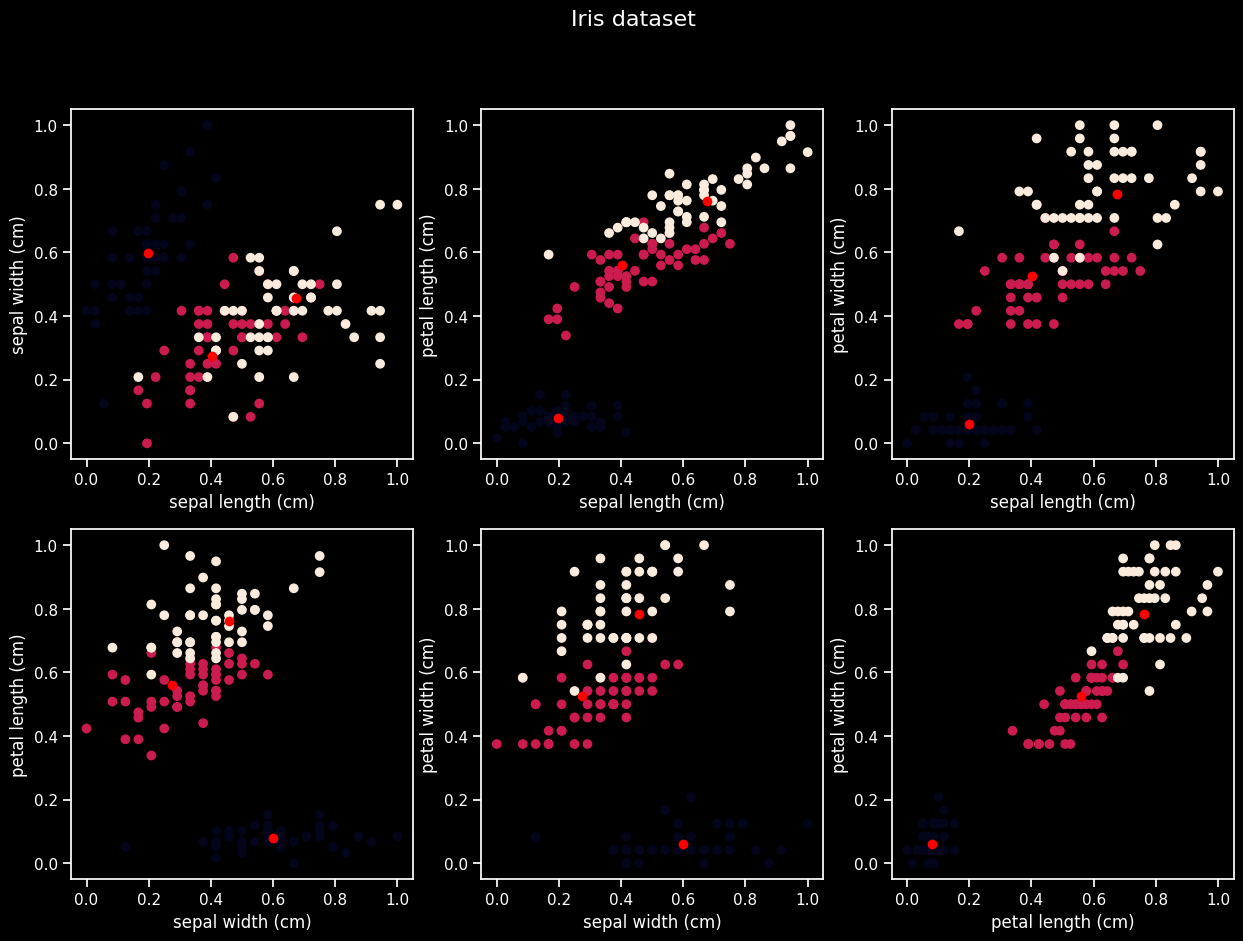

In [667]:
def train(
    model: KohonenMap,
    x: Nums,
    alpha: float,
    sigma: float,
    learning_rate: float,
    num_epoches: int,
):
    sigma_start = sigma
    learning_rate_start = learning_rate

    learning_rate = learning_rate_start
    sigma = sigma_start

    indices = np.arange(len(x))
    np.random.shuffle(indices)

    for i in range(num_epoches):
        model.fit(x[indices], alpha, sigma, learning_rate)

        sigma = sigma_start * (1 - i / num_epoches)
        learning_rate = learning_rate_start * (1 - i / num_epoches)


kmap = KohonenMap(4, Map2D(1, 3))
train(kmap, train_x, 0.01, 1, 0.01, 1000)
plot_centroids(kmap.weights, kmap.map.coords.reshape(kmap.map.x, kmap.map.y, 2));

In [668]:
predicted = kmap.predict(test_x)
y_true = np.argmax(test_y, axis=1)
predicted

array([0, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 0,
       2, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0,
       0])

In [669]:
def count_labels(num_clusters, predicted, labels):
    mapping = {cluster: [] for cluster in range(num_clusters)}

    for cluster, label in zip(predicted, labels):
        mapping[cluster].append(label)

    for cluster in mapping:
        most_common = Counter(mapping[cluster]).most_common(1)
        if len(most_common) == 0:
            most_common = 0
        else:
            most_common = most_common[0][0]
            
        mapping[cluster] = most_common

    cluster_labels = list(mapping.values())
    return cluster_labels

cluster_classes = count_labels(kmap.neuron_count, predicted, [int(x) for x in y_true])
cluster_classes

[0, 1, 2]

In [670]:
map_cluster_to_class = {i: cluster_classes[i] for i in range(kmap.neuron_count)}

sklearn.metrics.accuracy_score(y_true, [predicted[i] for i in range(len(predicted))])

0.9555555555555556

[255, 0, 0] setosa
[0, 255, 0] versicolor
[0, 0, 255] virginica
[0, 0, 0] none


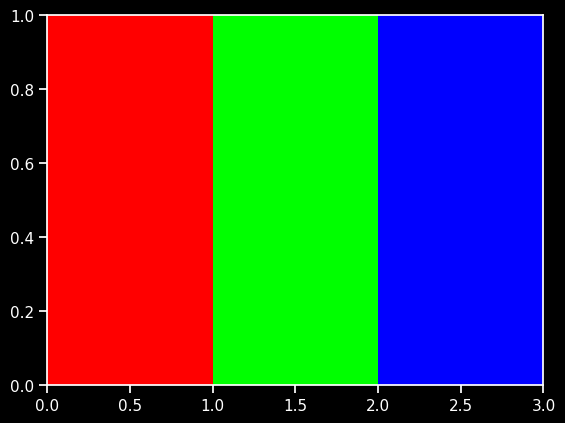

In [671]:
def plot_map2d(coords, labels, target_names, color_mapping):
    rows, cols, _ = coords.shape

    data_to_plot = [color_mapping[l] for l in labels]
    data_to_plot = np.array(data_to_plot).reshape((rows, cols, 3)).astype(np.uint8)
    fig, ax = plt.subplots()

    for color in list(color_mapping.keys()):
        print(color_mapping[color], target_names[color])

    ax.pcolormesh(data_to_plot);

plot_map2d(kmap.map.coords.reshape((kmap.map.x, kmap.map.y, 2)), cluster_classes, [*target_names, "none"], {
        0: [255, 0, 0],
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [0, 0, 0],
    })

Изучим весь датасет

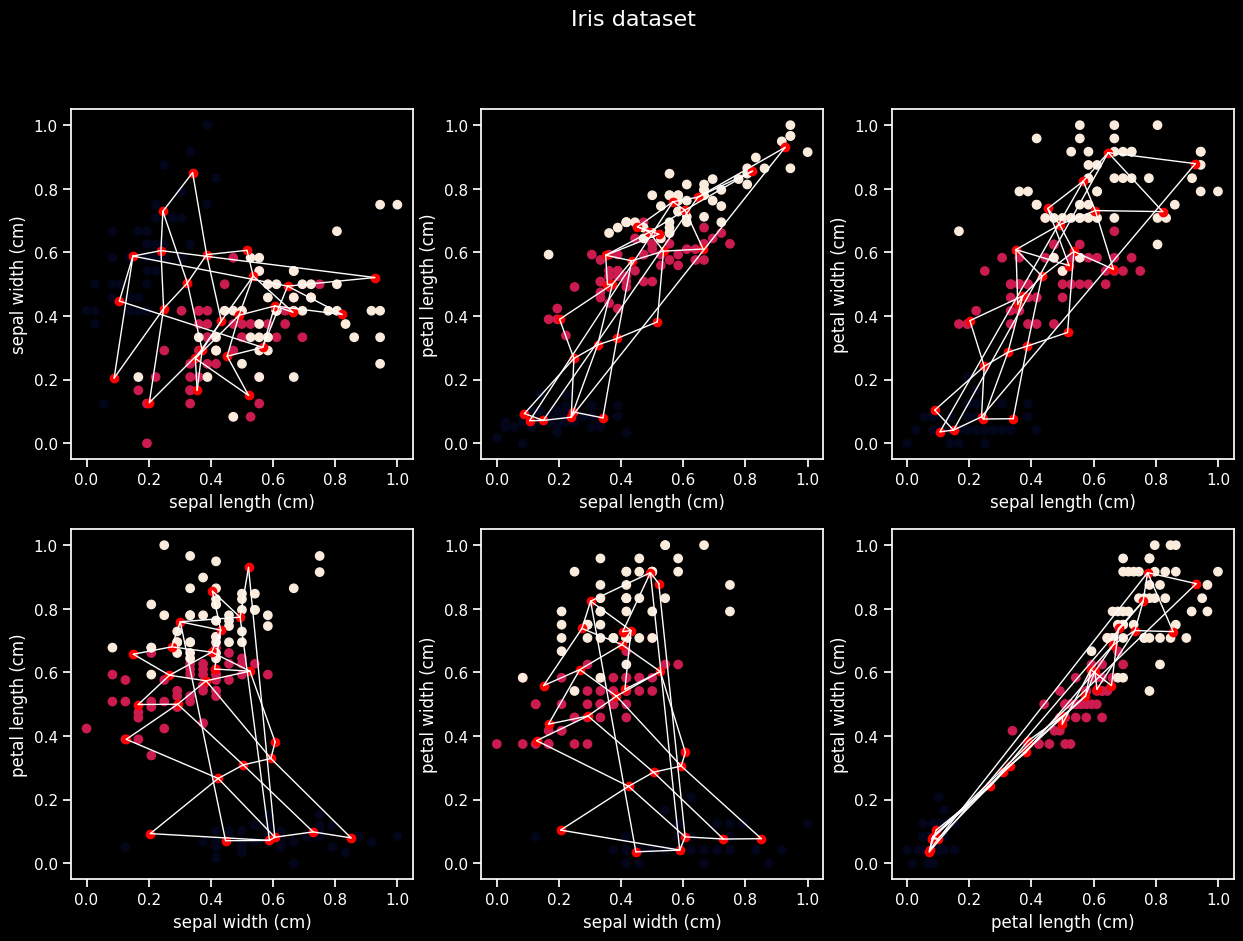

In [672]:
analysys_kmap = KohonenMap(4, Map2D(5, 5))
train(analysys_kmap, X, 0.01, 1, 0.01, 1000)
plot_centroids(analysys_kmap.weights, analysys_kmap.map.coords.reshape(analysys_kmap.map.x, analysys_kmap.map.y, 2));

In [673]:
cluster_classes = count_labels(analysys_kmap.neuron_count, analysys_kmap.predict(X), [int(x) for x in np.argmax(Y, axis=1)])
cluster_classes

[1, 1, 1, 0, 0, 2, 2, 1, 0, 0, 2, 2, 1, 0, 0, 2, 2, 1, 0, 0, 2, 2, 1, 0, 0]

In [674]:
sklearn.metrics.accuracy_score(np.argmax(Y, axis=1), [cluster_classes[i] for i in analysys_kmap.predict(X)])

0.9666666666666667

[255, 0, 0] setosa
[0, 255, 0] versicolor
[0, 0, 255] virginica
[0, 0, 0] none


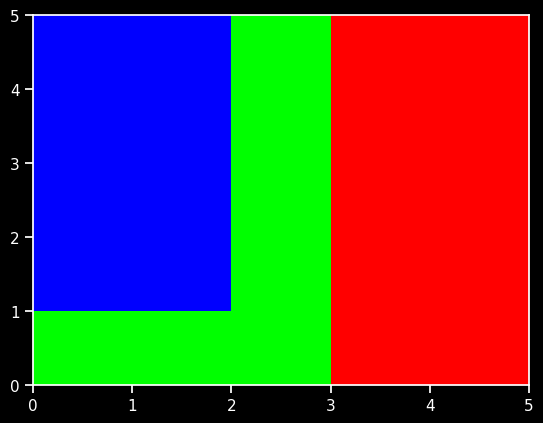

In [675]:
plot_map2d(analysys_kmap.map.coords.reshape((analysys_kmap.map.x, analysys_kmap.map.y, 2)), cluster_classes, [*target_names, "none"], {
        0: [255, 0, 0],
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [0, 0, 0],
    })